run_tcn_experiment.py

Usage:
/    python run_tcn_experiment.py <config_index>

This script will:
 1) Load the list of prebuilt TCN hyperparameter configs from tcn_configs.py
 2) Pick one config via the command-line index
 3) Load train.npy / test.npy (each a dict with keys 'X','Y')
 4) Build, train, evaluate the TCN model
 5) Save per-experiment summary under results/exp_<idx>/

In [6]:
import os
import sys
import numpy as np
import random



# Keras / TensorFlow
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import backend as K
import tensorflow as tf
import time      

# TCN layer
from tcn import TCN

# our configs
from tcn_configs import tcn_configs


#  logs/ folder exists (optional, for safety)
#os.makedirs("logs", exist_ok=True)

#  results/ folder exists
os.makedirs("results", exist_ok=True)


ncpus = int(os.environ.get("PBS_NCPUS", 1))
tf.config.threading.set_intra_op_parallelism_threads(ncpus)
tf.config.threading.set_inter_op_parallelism_threads(ncpus)




seed = 42
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)






In [2]:
#pip install keras-tcn --no-deps

In [7]:
import ast

import os, json, hashlib, ast


#def config_hash(cfg):
#    """
#    Canonical MD5 hash of a hyper‑param dict.
#    """
#    s = json.dumps(cfg, sort_keys=True)
#    return hashlib.md5(s.encode("utf-8")).hexdigest()


def normalize_config(cfg):
    normalized = {}
    for k, v in cfg.items():
        if isinstance(v, float):
            # Round floats to avoid precision mismatch
            normalized[k] = round(v, 6)
        elif isinstance(v, list):
            # Normalize each element in list
            normalized[k] = [
                round(i, 6) if isinstance(i, float) else i for i in v
            ]
        elif isinstance(v, str):
            # Strip any whitespace from strings
            normalized[k] = v.strip()
        else:
            normalized[k] = v
    return normalized

def config_hash(cfg):
    normalized = normalize_config(cfg)
    s = json.dumps(normalized, sort_keys=True)
    return hashlib.md5(s.encode("utf-8")).hexdigest()




def load_tested_configs(file_path):
    """
    Parse your results/tcn_metrics_new.txt,
    split on “=== Experiment” and turn each block
    back into a dict of hyper‑parameters.
    """
    if not os.path.exists(file_path):
        return []
    text = open(file_path).read()
    blocks = text.split("=== Experiment")[1:]
    tested = []
    for blk in blocks:
        params = {}
        for line in blk.splitlines():
            if ":" not in line:
                continue
            k, v = line.split(":", 1)
            k = k.strip()
            v = v.strip()
            try:
                # Try to convert to int, float, list, or bool
                v = ast.literal_eval(v)
            except Exception:
                # Fallback to stripped string
                v = v.strip()
            params[k] = v
        tested.append(params)
    return tested


def load_tested_hashes(file_path):
    tested_hashes = set()
    tested_configs = load_tested_configs(file_path)
    for cfg in tested_configs:
        tested_hashes.add(config_hash(cfg))
    return tested_hashes



In [8]:

SUMMARY       = os.path.join("results", "tcn_metrics_new.txt")
tested_list   = load_tested_configs(SUMMARY)
tested_hashes = {config_hash(cfg) for cfg in tested_list}
print(f"[INFO] {len(tested_hashes)} hyper‑parameter sets already tested")



[INFO] 0 hyper‑parameter sets already tested


1) pick config index from CLI


=== Experiment 2/47 ===
{'nb_filters': 128, 'kernel_size': 23, 'nb_stacks': 6, 'dilations': [1, 2, 4, 8, 16, 32], 'dropout_rate': 0.0, 'padding': 'causal', 'return_sequences': False, 'use_skip_connections': True, 'use_batch_norm': True, 'use_layer_norm': False, 'go_backwards': False, 'return_state': False, 'batch_size': 128, 'dense_units': 128, 'num_dense_layers': 8, 'dense_activation': 'relu', 'dense_dropout': 0.0}
New config: {'nb_filters': 128, 'kernel_size': 23, 'nb_stacks': 6, 'dilations': [1, 2, 4, 8, 16, 32], 'dropout_rate': 0.0, 'padding': 'causal', 'return_sequences': False, 'use_skip_connections': True, 'use_batch_norm': True, 'use_layer_norm': False, 'go_backwards': False, 'return_state': False, 'batch_size': 128, 'dense_units': 128, 'num_dense_layers': 8, 'dense_activation': 'relu', 'dense_dropout': 0.0}
New config hash: 54f359b87377b707152752c0a5cbdeac
Number of existing hashes: 0
Is this hash already tested? False
After TCN: (None, 128)
→ skipping GlobalAveragePooling1D,

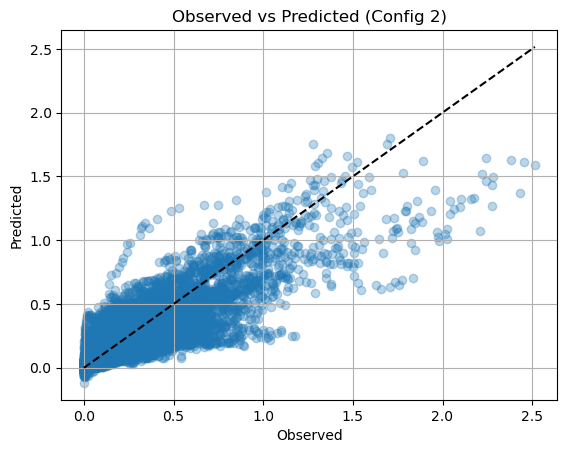

In [15]:
#####Jupyter notebook############
##### Jupyter Notebook Mode #####
import sys

# Simulate command-line argument
sys.argv = ['run_tcn_experiment_all.py', '2']  # Replace '0' with your desired config index

# it simulates python run_tcn_experiment_all.py 0 on Terminal




# Safety check: Ensure the index is valid
try:
    idx = int(sys.argv[1])
except (IndexError, ValueError):
    print("Usage: python run_tcn_experiment.py <config_index>", file=sys.stderr)
    raise SystemExit(1)

# Validate index against available configs
if idx < 0 or idx >= len(tcn_configs):
    print(f"Config index must be in [0..{len(tcn_configs) - 1}]", file=sys.stderr)
    raise SystemExit(1)

# Load the config
config = tcn_configs[idx]
print(f"\n=== Experiment {idx}/{len(tcn_configs) - 1} ===")
print(config)


##########Python mode ################

# if len(sys.argv) != 2:
#     print("Usage: python run_tcn_experiment.py <config_index>", file=sys.stderr)
#     sys.exit(1)

# idx = int(sys.argv[1])
# if idx < 0 or idx >= len(tcn_configs):
#     print(f"Config index must be in [0..{len(tcn_configs)-1}]", file=sys.stderr)
#     sys.exit(1)

# config = tcn_configs[idx]
# print(f"\n=== Experiment {idx}/{len(tcn_configs)-1} ===")
# print(config)



########pick and skip########
h = config_hash(config)

# Debug prints
print("New config:", config)
print("New config hash:", h)
print("Number of existing hashes:", len(tested_hashes))

import pprint

# Compare new config with all tested configs
for i, old_cfg in enumerate(tested_list):
    if config_hash(old_cfg) == h:
        print(f"\n[DEBUG] Matching hash found at index {i}, comparing configs:")
        print("→ New config:")
        pprint.pprint(config)
        print("→ Loaded config:")
        pprint.pprint(old_cfg)
        print("\n→ Difference in keys/values:")
        for key in config:
            if key not in old_cfg:
                print(f"  Key missing in old config: {key}")
            elif config[key] != old_cfg[key]:
                print(f"  Key: {key} — New: {config[key]} | Old: {old_cfg[key]}")
        for key in old_cfg:
            if key not in config:
                print(f"  Extra key in old config: {key}")
        break


print("Is this hash already tested?", h in tested_hashes)





if h in tested_hashes:
    print(f"[SKIP] Experiment {idx} skipped (already in {SUMMARY})")
    sys.exit(0)
# —otherwise— continue on to training…





# 2) load data
train_dict = np.load('train.npy', allow_pickle=True).item()
test_dict  = np.load('test.npy',  allow_pickle=True).item()
train_x, train_y = train_dict['X'], train_dict['Y']
test_x,  test_y  = test_dict ['X'], test_dict ['Y']


# 3) normalize features (per-feature z-score)
def normalize(X):
    mean = X.mean(axis=0, keepdims=True)
    std  = X.std(axis=0, keepdims=True) + 1e-6
    return (X - mean) / std

train_x = normalize(train_x)
test_x  = normalize(test_x)


# 4) custom RMSE metric for Keras
def rmse(y_true, y_predicted_y):
    return K.sqrt(K.mean(K.square(y_predicted_y - y_true)))


# 5) build model factory
def build_model(cfg):
    inp = Input(shape=(train_x.shape[1], train_x.shape[2]))
    x = TCN(
        nb_filters=cfg["nb_filters"],
        kernel_size=cfg["kernel_size"],
        nb_stacks=cfg["nb_stacks"],
        dilations=cfg["dilations"],
        padding=cfg["padding"],
        dropout_rate=cfg["dropout_rate"],
        return_sequences=cfg["return_sequences"],
        use_skip_connections=cfg.get("use_residual", True),
        use_batch_norm=cfg.get("use_batch_norm", False),
        use_layer_norm=cfg.get("use_layer_norm", False),
        go_backwards=cfg.get("go_backwards", False),
        return_state=cfg.get("return_state", False),
        activation='relu',
        kernel_initializer='he_normal'
    )(inp)
    print("After TCN:", x.shape)

   # if not cfg["return_sequences"]:
   #     x = GlobalAveragePooling1D()(x)
    #x = GlobalAveragePooling1D()(x) if not config["return_sequences"] else x
    if len(x.shape) == 3:
       x = GlobalAveragePooling1D()(x)
       print("→ after GlobalAveragePooling1D, x shape:", x.shape)
    else:
       print("→ skipping GlobalAveragePooling1D, already 2D, x shape:", x.shape)
       print(" → after GlobalAveragePooling1D:", x.shape)

#    x = Dense(cfg["dense_units"], activation='relu')(x)
#    x = Dropout(0.4)(x)
#    out = Dense(train_y.shape[1], activation='linear')(x)
#    print(" → final output shape:", out.shape)

    for _ in range(cfg['num_dense_layers']):
        x = Dense(cfg['dense_units'], activation=cfg['dense_activation'])(x)
        if cfg.get('dense_dropout', 0.0) > 0.0:
            x = Dropout(cfg['dense_dropout'])(x)

    out = Dense(train_y.shape[1], activation="linear")(x)
    print(" → final output shape:", out.shape)

    model = Model(inp, out)
    model.compile(
        optimizer='adam',
        loss=rmse,
        metrics=['mae', rmse]
    )
    return model


# 6) instantiate & train

# ─── Define the time‑limit callback ───────────────────

class TimeLimitCallback(tf.keras.callbacks.Callback):
    def __init__(self, max_time_per_epoch=600):
        super().__init__()
        self.max_time = max_time_per_epoch
        self.timed_out = False

    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_start = time.time()

#    def on_epoch_end(self, epoch, logs=None):
#        epoch_duration = time.time() - self.epoch_start
#        if epoch_duration > self.max_time:
#            print(f"\n[TimeLimit] Epoch {epoch} took {epoch_duration:.1f}s > {self.max_time}s—stopping.")
#            self.model.stop_training = True

    def on_train_batch_end(self, batch, logs=None):
        elapsed = time.time() - self.epoch_start

        if elapsed > self.max_time:
            print(f"\n[TimeLimit] Batch {batch} pushed epoch time to {elapsed:.1f}s > {self.max_time}s → stopping.")
            self.model.stop_training = True
            self.timed_out = True 

time_cb = TimeLimitCallback(max_time_per_epoch=20000)



#------ If exeecds job walltime__________________________________________________

import time
import tensorflow as tf

# ── callback to stop training when total job time exceeds a threshold ──
class WalltimeCallback(tf.keras.callbacks.Callback):
    def __init__(self, start_time, max_seconds, margin=60):
        """
        start_time: timestamp when job/script began
        max_seconds: total allowed run (e.g. 11*3600 for 11h)
        margin: seconds left to leave as buffer (default 1 min)
        """
        super().__init__()
        self.start_time = start_time
        self.max_seconds = max_seconds
        self.margin = margin
        self.timed_out = False

    def on_train_batch_end(self, batch, logs=None):
        elapsed = time.time() - self.start_time
        if elapsed + self.margin > self.max_seconds:
            print(f"\n[WalltimeCallback] hit {elapsed:.0f}s > {self.max_seconds}s — stopping now.")
            self.model.stop_training = True
            self.timed_out = True


# record when we began (right before build/train)
job_start = time.time()
MAX_RUN = 111 * 3600    # 11 hours in seconds
wall_cb = WalltimeCallback(start_time=job_start, max_seconds=MAX_RUN)


model = build_model(config)
callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5),
    time_cb,
    wall_cb,
]


try:
    history = model.fit(
        train_x, train_y,
        validation_split=0.1,
        epochs=500,
        batch_size=config["batch_size"],
        callbacks=callbacks,
        verbose=1,
        shuffle=False
    )
except tf.errors.ResourceExhaustedError as e:
    print(f"OOM error caught for config: {config}")
    print(e)
    history = None  # or skip prediction/logging for this run




# 7) predict & compute metrics
predicted_y = model.predict(test_x)
#mse_val = np.mean((predicted_y - test_y)**2)
mse_val = np.mean(np.square(predicted_y - test_y))
rmse_val = np.sqrt(mse_val)
mae_val = np.mean(np.abs(predicted_y - test_y))
pearson_corr = np.corrcoef(test_y.flatten(), predicted_y.flatten())[0, 1]


from sklearn.metrics import r2_score
r2_val = r2_score(test_y.reshape(-1), predicted_y.reshape(-1))


print(f"Metrics → mse: {mse_val:.4f}, rmse: {rmse_val:.4f}, mae: {mae_val:.4f}, r2: {r2_val:.4f}, pearson: {pearson_corr:.4f}")

# 8) save summary
#outdir = os.path.join("results", f"exp_{idx}")
#os.makedirs(outdir, exist_ok=True)

#with open(os.path.join(outdir, "summary.txt"), "w") as f:
 #   f.write(f"config = {repr(config)}\n")
 #   f.write(f"mse={mse_val:.6f}, rmse={rmse_val:.6f}, mae={mae_val:.6f}, r2={r2_val:.6f}\n")

#print(f"→ Saved results in {outdir}")

import os
import matplotlib.pyplot as plt

# 1. Make sure results/ directory exists
os.makedirs("results", exist_ok=True)

# 2. Update results dictionary with hyperparameters + metrics
results = {
    "nb_filters": config["nb_filters"],
    "kernel_size": config["kernel_size"],
    "nb_stacks": config["nb_stacks"],
    "dilations": config["dilations"],
    "dropout_rate": config["dropout_rate"],
    "padding": config["padding"],
    "return_sequences": config["return_sequences"],
    "use_skip_connections": config["use_skip_connections"],
    "use_batch_norm": config.get("use_batch_norm", False),
    "use_layer_norm": config.get("use_layer_norm", False),
    "go_backwards": config.get("go_backwards", False),
    "return_state": config.get("return_state", False),
    "batch_size": config.get("batch_size", 128),
    "dense_units": config.get("dense_units", 128),

    #New
    "dense_activation": config.get("dense_activation", "linear"),
    "dense_dropout": config.get("dense_dropout", 0.4),
    "num_dense_layers": config.get("num_dense_layers", 1),

    # Metrics
    "mse": mse_val,
    "rmse": rmse_val,
    "mae": mae_val,
    "r2": r2_val,
    "pearson": pearson_corr
}

# 3. Append to a unified summary file
#summary_path = "results/summary_metrics.txt"

# Safe: one file per job
job_id = os.environ.get('PBS_ARRAY_INDEX', 'unknown')  # Get the job ID from environment



#summary_path = f"results/summary_metrics_{job_id}.txt"


####
# === Save results into grouped summary files ===

# Determine batch name based on idx
#if 0 <= idx <= 499:
#    batch_name = "0_499"
#elif 500 <= idx <=999:
#    batch_name = "500_999"
#elif 1000 <= idx <= 1499:
#    batch_name = "1000_1499"
#elif 1500 <= idx <= 1999:
#    batch_name = "1500_1999"
#elif 2000 <= idx <= 2600:
#    batch_name = "2000_2499"
#elif 2500 <= idx <= 3000:
#    batch_name = "2500_3000"
#else:
#    batch_name = "other"

# Set summary path
summary_path = f"results/tcn_metrics3.txt"

# Append results to the correct batch summary file


#with open(summary_path, "a") as f:
#    f.write(f"=== Experiment {idx} ===\n")
#    for key, value in results.items():
#        f.write(f"{key}: {value}\n")
#    f.write("\n")



# with open(summary_path, "a") as f:
#     if time_cb.timed_out:
     
#         # Write the config but mark it rejected
#         f.write(f"=== Experiment {idx} REJECTED ===\n")
#         for key, val in config.items():
#             f.write(f"{key}: {val}\n")
#         f.write("\n")
#     else:
#         # Your existing code to write out the results dict
#         f.write(f"=== Experiment {idx} ===\n")
#         for key, val in results.items():
#             f.write(f"{key}: {val}\n")
#         f.write("\n")

# print(f"Experiment {idx} {'rejected' if time_cb.timed_out else 'complete'}")



with open(summary_path, "a") as f:
    status = "REJECTED" if time_cb.timed_out else ""
    f.write(f"=== Experiment {idx} {status} ===\n")

    # Write only results (which include both config and metrics)
    for key, val in results.items():
        f.write(f"{key}: {val}\n")
    
    f.write("\n")

print(f"Experiment {idx} {'rejected' if time_cb.timed_out else 'complete'}")






# 4. Save scatter plot directly in results/ as fig_expX.png
plt.figure()
plt.scatter(test_y.flatten(), predicted_y.flatten(), alpha=0.3)
plt.plot([min(test_y.flatten()), max(test_y.flatten())],
         [min(test_y.flatten()), max(test_y.flatten())], 'k--')
plt.xlabel("Observed")
plt.ylabel("Predicted")
plt.title(f"Observed vs Predicted (Config {idx})")

#plt.ylabel("predicted_yicted")
#plt.title(f"Observed vs predicted_yicted (Config {idx})")
plt.grid(True)
##plt.savefig(f"results/fig_exp{idx}.png")


# 5. Final print
#print(f"Experiment {idx} complete. Summary and figure saved in results/")





Text(0.5, 1.0, 'Observed vs Predicted (Config 0)')

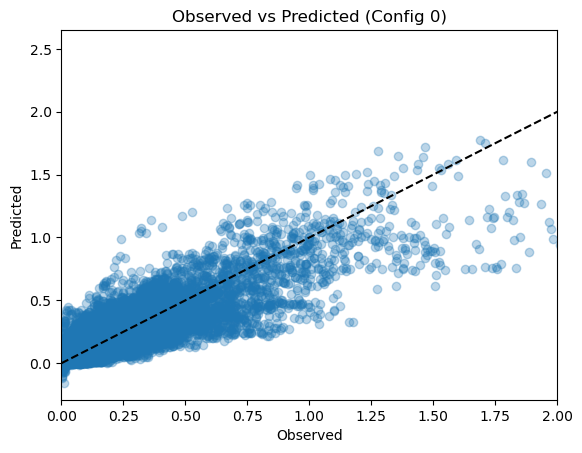

In [11]:
plt.figure()
plt.scatter(test_y.flatten(), predicted_y.flatten(), alpha=0.3)
plt.plot([min(test_y.flatten()), max(test_y.flatten())],
         [min(test_y.flatten()), max(test_y.flatten())], 'k--')
plt.xlabel("Observed")
plt.ylabel("Predicted")
plt.xlim(-0.0, 2)  
#plt.ylim(-5, 15)  

plt.title(f"Observed vs Predicted (Config {idx})")

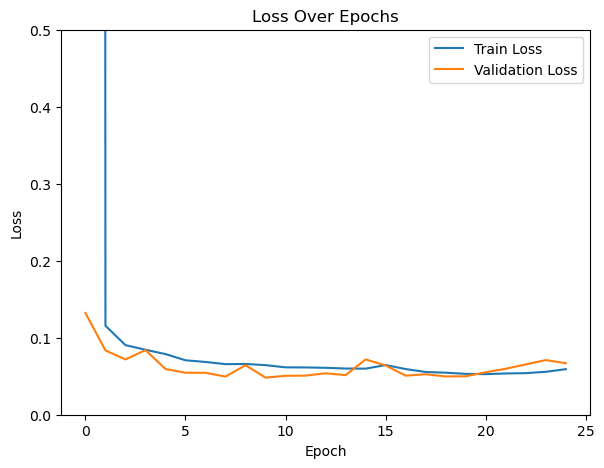

In [14]:
# Plotting training history
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0, 0.5) 
plt.legend()